# Alphavirus RdRp Co-Variance Analysis

## Direct Coupling Analysis (DCA), direct information (DI)

Traditional covariance methods can identify correlated variables (like amino acid residues in proteins that change together) but can't differentiate if these correlations are direct (two variables directly influencing each other) or indirect (their correlation is due to both being influenced by a third variable).  

DCA goes beyond traditional covariance methods by attempting to infer direct interactions between variables (e.g., amino acid residues in a protein) from large multiple sequence alignments (MSAs). The output of DCA includes scores for pairs of positions in a sequence, indicating the strength and likelihood that they interact directly, rather than merely appearing to interact due to indirect effects mediated by other positions.  

### How DCA Works
**Multiple Sequence Alignment**: DCA begins with an MSA, which aligns sequences from similar proteins across different species or variants. This alignment helps identify conserved and variable positions across sequences.    

**Covariance Calculation**: DCA calculates the covariance for each pair of positions in the MSA. High covariance suggests that changes in one position often coincide with changes in another, which might indicate some form of interaction.    

**Inferring Direct Interactions**:
Unlike simpler covariance methods, DCA uses statistical models to differentiate direct interactions from indirect correlations.
The model assigns a score to each possible pair of residues, with higher scores indicating a stronger likelihood of direct interaction.   

**Inversion of the Covariance Matrix**: One approach within DCA involves inverting the covariance matrix of the alignment to extract direct information, which helps in separating direct from indirect interactions.

In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Entrez, SeqIO, AlignIO
from Bio.PDB import PDBParser, PDBIO, Chain

import ast

pd.set_option('display.max_columns', 110)

## Trim aligment file

In [ ]:
# pydca trim_by_refseq <biomolecule>  <alignment.fa>  <refseq_file.fa> --remove_all_gaps --verbose
# pydca trim_by_refseq protein data/alphavirus_nsP_psiblast_rvdb_seq_idt30_v02_aligned.fasta  data/CHIKV_nsP1234.fasta --remove_all_gaps --verbose

## Deleting sequences with X

In [ ]:
# input_file = 'data/nsP/alphavirus_nsP_psiblast_rvdb_seq_idt30_filtered_aligned_no_IDR.fasta'
# out_file = 'data/nsP/alphavirus_nsP_psiblast_rvdb_seq_idt30_filtered_aligned_no_IDR_X.fasta'

# count = 0
# for align in AlignIO.read(input_file, 'fasta'):
#     if 'X' in align.seq:
#         count +=1
#     else:
#         with open(out_file, 'a') as file:
#             file.write(f">{align.id}\n")
#             file.write(f"{align.seq}\n")

# print(f'{count} sequences with X removed')

## Run DCA analysis
for this I used the MSA file, from the psi-blast from the neff analysis

In [ ]:
#plmdca compute_fn protein data/alphavirus_nsP_psiblast_rvdb_seq_idt30_v02_aligned_Trimmed.fa --apc --seqid 0.8 --lambda_h 1.0 --lambda_J 20.0 --max_iterations 500 --num_threads 16 --output_dir results/DCA/nsP/ results/DCA/ --verbose

#plmdca compute_fn protein data/alphavirus_nsP_psiblast_rvdb_seq_idt30_v02_aligned_Trimmed_no_IDR.fa --refseq_file data/CHIKV_nsP1234_no_IDR.fasta --apc --seqid 0.9999 --lambda_h 1.0 --lambda_J 20.0 --max_iterations 500 --num_threads 64 --output_dir results/DCA/nsP/ --verbose

## Covariance analysis on nsP4

In [ ]:
def Zscore(column_val):
    m = np.mean(column_val)
    std = np.std(column_val)
    zscore = [((x - m)/std) for x in column_val]
    return zscore

In [3]:
names = ['first_site', 'second_site', 'APC']
cov = pd.read_csv('results/DCA/nsP/PLMDCA_apc_fn_scores_Trimmed_alphavirus_nsP_psiblast_rvdb_seq_idt30_filtered_aligned_no_IDR_X.txt', skiprows=12, sep='\s+', header=None, names=names)

cov['Tuple'] =  cov.apply(lambda row: (int(row['first_site']), int(row['second_site'])), axis=1)
cov = cov[['first_site', 'second_site', 'Tuple', 'APC']]
cov

,first_site,second_site,Tuple,APC
0,225,681,"(225, 681)",2.208674
1,495,1114,"(495, 1114)",2.113225
2,451,2008,"(451, 2008)",2.040878
3,128,376,"(128, 376)",1.786685
4,1030,1328,"(1030, 1328)",1.717767
...,...,...,...,...
2536873,1170,1896,"(1170, 1896)",-0.123549
2536874,779,1896,"(779, 1896)",-0.123775
2536875,1392,1896,"(1392, 1896)",-0.154851
2536876,1074,1896,"(1074, 1896)",-0.173836


In [4]:
cov.second_site.max()

2253

In [5]:
cov['Zscore'] = Zscore(cov['APC'])
cov.head()

,first_site,second_site,Tuple,APC,Zscore
0,225,681,"(225, 681)",2.208674,109.961490
1,495,1114,"(495, 1114)",2.113225,105.209453
2,451,2008,"(451, 2008)",2.040878,101.607546
3,128,376,"(128, 376)",1.786685,88.952236
4,1030,1328,"(1030, 1328)",1.717767,85.521068


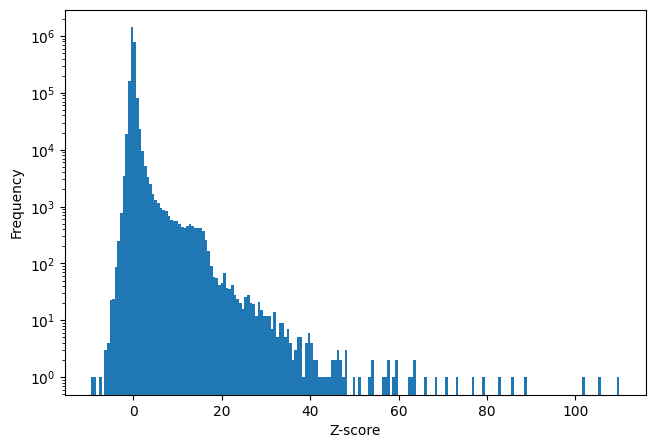

In [6]:
plt.figure(figsize=(7.5,5))
cov['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
plt.yscale('log')
#plt.savefig('results/DCA/nsP4/mfdca_nsp4_extended_Zscore_hist.png', dpi=400)
plt.show()

## Identifing covarinace between nsP proteins

### nsP2-nsP4 interaction 
>nsP1 | mRNA-capping enzyme | PRO_0000227761 | 1-535   
>nsP2 | Protease nsP2 | PRO_0000227762	| 536-1333     

In [7]:
ref_CHYKV = str(SeqIO.read('data/CHIKV_nsP1234_no_IDR.fasta', 'fasta').seq)
ref_CHYKV

'MDPVYVDIDADSAFLKALQRAYPMFEVEPRQVTPNDHANARAFSHLAIKLIEQEIDPDSTILDIGSAPARRMMSDRKYHCVCPMRSAEDPERLANYARKLASAAGKVLDRNISGKIGDLQAVMAVPDTETPTFCLHTDVSCRQRADVAIYQDVYAVHAPTSLYHQAIKGVRLAYWVGFDTTPFMYNAMAGAYPSYSTNWADEQVLKAKNIGLCSTDLTEGRRGKLSIMRGKKLEPCDRVLFSVGSTLYPESRKLLKSWHLPSVFHLKGKLSFTCRCDTVVSCEGYVVKRITMSPGLYGKTTGYAVTHHADGFLMCKTTDTVDGERVSFSVCTYVPATICDQMTGILATEVTPEDAQKLLVGLNQRIVVNGRTQRNTNTMKNYMIPVVAQAFSKWAKECRKDMEDEKLLGVRERTLTCCCLWAFKKQKTHTVYKRPDTQSIQKVQAEFDSFVVPSLWSSGLSIPLRTRIKWLLSKVPKTDLTPYSGDAQEARDAEKEAEEEREAELTLEALPPLQAAQEDVQVEIDVEQLEDRAGAGIIETPRGAIKVTAQPTDHVVGEYLVLSPQTVLRSQKLSLIHALAEQVKTCTHSGRAGRYAVEAYDGRVLVPSGYAISPEDFQSLSESATMVYNEREFVNRKLHHIAMHGPALNTDEESYELVRAERTEHEYVYDVDQRRCCKKEEAAGLVLVGDLTNPPYHEFAYEGLKIRPACPYKIAVIGVFGVPGSGKSAIIKNLVTRQDLVTSGKKENCQEITTDVMRQRGLEISARTVDSLLLNGCNRPVDVLYVDEAFACHSGTLLALIALVRPRQKVVLCGDPKQCGFFNMMQMKVNYNHNICTQVYHKSISRRCTLPVTAIVSSLHYEGKMRTTNEYNKPIVVDTTGSTKPDPGDLVLTCFRGWVKQLQIDYRGHEVMTAAASQGLTRKGVYAVRQKVNENPLYASTSEHVNVLLTRTEGKLVWKTLSGDPWIKTLQNPPKGNFKATIKEWEVEHASIMAGICSH

In [8]:
# nsP1
start = 1
stop= 535
ref_CHYKV[start-1:stop]

'MDPVYVDIDADSAFLKALQRAYPMFEVEPRQVTPNDHANARAFSHLAIKLIEQEIDPDSTILDIGSAPARRMMSDRKYHCVCPMRSAEDPERLANYARKLASAAGKVLDRNISGKIGDLQAVMAVPDTETPTFCLHTDVSCRQRADVAIYQDVYAVHAPTSLYHQAIKGVRLAYWVGFDTTPFMYNAMAGAYPSYSTNWADEQVLKAKNIGLCSTDLTEGRRGKLSIMRGKKLEPCDRVLFSVGSTLYPESRKLLKSWHLPSVFHLKGKLSFTCRCDTVVSCEGYVVKRITMSPGLYGKTTGYAVTHHADGFLMCKTTDTVDGERVSFSVCTYVPATICDQMTGILATEVTPEDAQKLLVGLNQRIVVNGRTQRNTNTMKNYMIPVVAQAFSKWAKECRKDMEDEKLLGVRERTLTCCCLWAFKKQKTHTVYKRPDTQSIQKVQAEFDSFVVPSLWSSGLSIPLRTRIKWLLSKVPKTDLTPYSGDAQEARDAEKEAEEEREAELTLEALPPLQAAQEDVQVEIDVEQLEDRAGA'

In [9]:
# nsP2 - size 798
start = 536
stop= 1333
ref_CHYKV[start-1:stop]

'GIIETPRGAIKVTAQPTDHVVGEYLVLSPQTVLRSQKLSLIHALAEQVKTCTHSGRAGRYAVEAYDGRVLVPSGYAISPEDFQSLSESATMVYNEREFVNRKLHHIAMHGPALNTDEESYELVRAERTEHEYVYDVDQRRCCKKEEAAGLVLVGDLTNPPYHEFAYEGLKIRPACPYKIAVIGVFGVPGSGKSAIIKNLVTRQDLVTSGKKENCQEITTDVMRQRGLEISARTVDSLLLNGCNRPVDVLYVDEAFACHSGTLLALIALVRPRQKVVLCGDPKQCGFFNMMQMKVNYNHNICTQVYHKSISRRCTLPVTAIVSSLHYEGKMRTTNEYNKPIVVDTTGSTKPDPGDLVLTCFRGWVKQLQIDYRGHEVMTAAASQGLTRKGVYAVRQKVNENPLYASTSEHVNVLLTRTEGKLVWKTLSGDPWIKTLQNPPKGNFKATIKEWEVEHASIMAGICSHQMTFDTFQNKANVCWAKSLVPILETAGIKLNDRQWSQIIQAFKEDKAYSPEVALNEICTRMYGVDLDSGLFSKPLVSVYYADNHWDNRPGGKMFGFNPEAASILERKYPFTKGKWNINKQICVTTRRIEDFNPTTNIIPANRRLPHSLVAEHRPVKGERMEWLVNKINGHHVLLVSGCSLALPTKRVTWVAPLGVRGADYTYNLELGLPATLGRYDLVVINIHTPFRIHHYQQCVDHAMKLQMLGGDSLRLLKPGGSLLIRAYGYADRTSERVICVLGRKFRSSRALKPPCVTSNTEMFFLFSNFDNGRRNFTTHVMNNQLNAAFVGQATRAGC'

In [33]:
# nsP3
start = 1334
stop= 1642
print(len(ref_CHYKV[start-1:stop]))
nsp3 = ref_CHYKV[start-1:stop]
print(nsp3)
print(ref_CHYKV[start-1:stop+5])

309
APSYRVKRMDIAKNDEECVVNAANPRGLPGDGVCKAVYKKWPESFKNSATPVGTAKTVMCGTYPVIHAVGPNFSNYSESEGDRELAAAYREVAKEVTRLGVNSVAIPLLSTGVYSGGKDRLTQSLNHLFTAMDSTDADVVIYCRDKEWEKKISEAIQMRTQVELLDEHISIDCDVVRVHPDSSLAGRKGYSTTEGALYSYLEGTRFHQTAVDMAEIYTMWPKQTEANEQVCLYALGESIESIRQKCPVDDADASSPPKTVPCLCRYAMTPERVTRLRMNHVTSIIVCSSFPLPKYKIEGVQKVKCSKVM
APSYRVKRMDIAKNDEECVVNAANPRGLPGDGVCKAVYKKWPESFKNSATPVGTAKTVMCGTYPVIHAVGPNFSNYSESEGDRELAAAYREVAKEVTRLGVNSVAIPLLSTGVYSGGKDRLTQSLNHLFTAMDSTDADVVIYCRDKEWEKKISEAIQMRTQVELLDEHISIDCDVVRVHPDSSLAGRKGYSTTEGALYSYLEGTRFHQTAVDMAEIYTMWPKQTEANEQVCLYALGESIESIRQKCPVDDADASSPPKTVPCLCRYAMTPERVTRLRMNHVTSIIVCSSFPLPKYKIEGVQKVKCSKVMYIFSS


In [11]:
nsP3_chikv_full = 'APSYRVKRMDIAKNDEECVVNAANPRGLPGDGVCKAVYKKWPESFKNSATPVGTAKTVMCGTYPVIHAVGPNFSNYSESEGDRELAAAYREVAKEVTRLGVNSVAIPLLSTGVYSGGKDRLTQSLNHLFTAMDSTDADVVIYCRDKEWEKKISEAIQMRTQVELLDEHISIDCDVVRVHPDSSLAGRKGYSTTEGALYSYLEGTRFHQTAVDMAEIYTMWPKQTEANEQVCLYALGESIESIRQKCPVDDADASSPPKTVPCLCRYAMTPERVTRLRMNHVTSIIVCSSFPLPKYKIEGVQKVKCSKVMLFDHNVPSRVSPREYRPSQESVQEASTTTSLTHSQFDLSVDGKILPVPSDLDADAPALEPALDDGAIHTLPSATGNLAAVSDWVMSTVPVAPPRRRRGRNLTVTCDEREGNITPMASVRFFRAELCPVVQETAETRDTAMSLQAPPSTATELSHPPISFGAPSETFPITFGDFNEGEIESLSSELLTFGDFLPGEVDDLTDSDWSTCSDTDDELRLDRAGG'
len(nsP3_chikv_full)

530

In [34]:
# nsP4
start = 1643
stop= 2253
nsp4 = ref_CHYKV[start-1:stop]
print(nsp4)
ref_CHYKV[start-1:stop]

YIFSSDTGPGHLQQKSVRQSVLPVNTLEEVHEEKCYPPKLDEAKEQLLLKKLQESASMANRSRYQSRKVENMKATIIQRLKRGCRLYLMSETPKVPTYRTTYPAPVYSPPINVRLSNPESAVAACNEFLARNYPTVSSYQITDEYDAYLDMVDGSESCLDRATFNPSKLRSYPKQHAYHAPSIRSAVPSPFQNTLQNVLAAATKRNCNVTQMRELPTLDSAVFNVECFKKFACNQEYWEEFAASPIRITTENLTTYVTKLKGPKAAALFAKTHNLLPLQEVPMDRFTVDMKRDVKVTPGTKHTEERPKVQVIQAAEPLATAYLCGIHRELVRRLNAVLLPNVHTLFDMSAEDFDAIIAAHFKPGDTVLETDIASFDKSQDDSLALTALMLLEDLGVDHSLLDLIEAAFGEISSCHLPTGTRFKFGAMMKSGMFLTLFVNTLLNITIASRVLEDRLTKSACAAFIGDDNIIHGVVSDELMAARCATWMNMEVKIIDAVVSQKAPYFCGGFILHDIVTGTACRVADPLKRLFKLGKPLAAGDEQDEDRRRALADEVVRWQRTGLIDELEKAVYSRYEVQGISVVVMSMATFASSRSNFEKLRGPVVTLYGGPK


'YIFSSDTGPGHLQQKSVRQSVLPVNTLEEVHEEKCYPPKLDEAKEQLLLKKLQESASMANRSRYQSRKVENMKATIIQRLKRGCRLYLMSETPKVPTYRTTYPAPVYSPPINVRLSNPESAVAACNEFLARNYPTVSSYQITDEYDAYLDMVDGSESCLDRATFNPSKLRSYPKQHAYHAPSIRSAVPSPFQNTLQNVLAAATKRNCNVTQMRELPTLDSAVFNVECFKKFACNQEYWEEFAASPIRITTENLTTYVTKLKGPKAAALFAKTHNLLPLQEVPMDRFTVDMKRDVKVTPGTKHTEERPKVQVIQAAEPLATAYLCGIHRELVRRLNAVLLPNVHTLFDMSAEDFDAIIAAHFKPGDTVLETDIASFDKSQDDSLALTALMLLEDLGVDHSLLDLIEAAFGEISSCHLPTGTRFKFGAMMKSGMFLTLFVNTLLNITIASRVLEDRLTKSACAAFIGDDNIIHGVVSDELMAARCATWMNMEVKIIDAVVSQKAPYFCGGFILHDIVTGTACRVADPLKRLFKLGKPLAAGDEQDEDRRRALADEVVRWQRTGLIDELEKAVYSRYEVQGISVVVMSMATFASSRSNFEKLRGPVVTLYGGPK'

In [13]:
nsp2_range = (536, 1333)
print("nsP2", nsp2_range[0], nsp2_range[1])

nsp4_range = (1643, 2253)
print("nsP4", nsp4_range[0], nsp4_range[1])

nsP2 536 1333
nsP4 1643 2253


In [14]:
mapping_nsp2 = dict(zip(range(536, 1334), range(1, 799)))
mapping_nsp3 = dict(zip(range(1334, 1642), range(1, 310)))
mapping_nsp4 = dict(zip(range(1643, 2254), range(1, 612)))

In [16]:
nsP24 = cov[(cov['first_site'].between(nsp2_range[0], nsp4_range[1])) & (cov['second_site'].between(nsp2_range[0], nsp4_range[1]))].copy()
nsP24

,first_site,second_site,Tuple,APC,Zscore
4,1030,1328,"(1030, 1328)",1.717767,85.521068
7,1074,1724,"(1074, 1724)",1.538849,76.613376
9,1392,1617,"(1392, 1617)",1.418813,70.637266
11,680,1697,"(680, 1697)",1.324988,65.966043
12,665,1727,"(665, 1727)",1.283811,63.915992
...,...,...,...,...,...
2536873,1170,1896,"(1170, 1896)",-0.123549,-6.151171
2536874,779,1896,"(779, 1896)",-0.123775,-6.162416
2536875,1392,1896,"(1392, 1896)",-0.154851,-7.709596
2536876,1074,1896,"(1074, 1896)",-0.173836,-8.654764


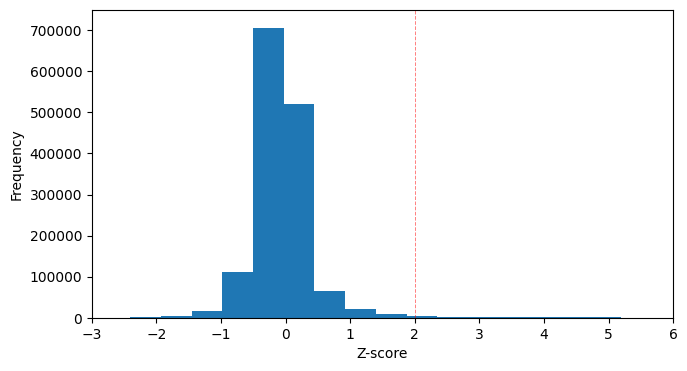

In [17]:
plt.figure(figsize=(7.5, 4))
nsP24['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
plt.xlim(-3,6)
plt.ylim(-0,750000)
plt.vlines(2, 0, 750000, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
#plt.savefig('results/DCA/nsP/mfdca_nsp24_Nterm_Zscore_hist.png', dpi=600, bbox_inches='tight')
plt.show()

In [18]:
nsP24['Zscore'].min()

-9.53450573934869

In [19]:
nsP24['first_site_prot'] = nsP24['first_site'].apply(lambda x: 'nsP2' if x in range(nsp2_range[0], nsp2_range[1]+1) else 'nsP4')
nsP24['second_site_prot'] = nsP24['second_site'].apply(lambda x: 'nsP2' if x in range(nsp2_range[0], nsp2_range[1]+1) else 'nsP4')

nsP24 = nsP24[['first_site_prot', 'first_site', 'second_site_prot', 'second_site', 'Tuple', 'APC', 'Zscore']]

nsP24

,first_site_prot,first_site,second_site_prot,second_site,Tuple,APC,Zscore
4,nsP2,1030,nsP2,1328,"(1030, 1328)",1.717767,85.521068
7,nsP2,1074,nsP4,1724,"(1074, 1724)",1.538849,76.613376
9,nsP4,1392,nsP4,1617,"(1392, 1617)",1.418813,70.637266
11,nsP2,680,nsP4,1697,"(680, 1697)",1.324988,65.966043
12,nsP2,665,nsP4,1727,"(665, 1727)",1.283811,63.915992
...,...,...,...,...,...,...,...
2536873,nsP2,1170,nsP4,1896,"(1170, 1896)",-0.123549,-6.151171
2536874,nsP2,779,nsP4,1896,"(779, 1896)",-0.123775,-6.162416
2536875,nsP4,1392,nsP4,1896,"(1392, 1896)",-0.154851,-7.709596
2536876,nsP2,1074,nsP4,1896,"(1074, 1896)",-0.173836,-8.654764


In [20]:
# load neff values
neff = pd.read_csv('results/neff/nsP_no_IDR_X_neff.csv')
neff

,Residue,Position,Neff
0,M,1,1.619574
1,D,2,3.951148
2,P,3,3.820830
3,V,4,1.128936
4,Y,5,3.759292
...,...,...,...
2248,Y,2249,1.000000
2249,G,2250,1.016835
2250,G,2251,1.008358
2251,P,2252,1.000000


In [21]:
df1 = nsP24.merge(neff, left_on='first_site', right_on='Position', how='left')
df1.rename(columns={'Neff': 'first_site_Neff', 'Residue':'first_site_residue'}, inplace=True)
df1.drop(columns='Position', axis=1, inplace=True)

df2 = df1.merge(neff, left_on='second_site', right_on='Position', how='left')
df2.rename(columns={'Neff': 'second_site_Neff', 'Residue':'second_site_residue'}, inplace=True)

cov_neff = df2[['Tuple', 
                'first_site_prot', 'first_site_residue', 'first_site', 'first_site_Neff',
                'second_site_prot', 'second_site_residue', 'second_site', 'second_site_Neff',
                            'APC', 'Zscore',]]

print("Number of possible significant interections", nsP24.query("APC > 0.5 & Zscore > 2").shape[0])

cov_neff = cov_neff.query("Zscore > 2")
cov_neff

Number of possible significant interections 177


,Tuple,first_site_prot,first_site_residue,first_site,first_site_Neff,second_site_prot,second_site_residue,second_site,second_site_Neff,APC,Zscore
0,"(1030, 1328)",nsP2,N,1030,2.423971,nsP2,A,1328,5.372184,1.717767,85.521068
1,"(1074, 1724)",nsP2,L,1074,3.421185,nsP4,R,1724,4.373344,1.538849,76.613376
2,"(1392, 1617)",nsP4,M,1392,4.189181,nsP4,I,1617,2.617878,1.418813,70.637266
3,"(680, 1697)",nsP2,E,680,2.433811,nsP4,S,1697,4.990098,1.324988,65.966043
4,"(665, 1727)",nsP2,H,665,5.418004,nsP4,R,1727,2.994622,1.283811,63.915992
...,...,...,...,...,...,...,...,...,...,...,...
17385,"(830, 1120)",nsP2,N,830,2.008655,nsP2,I,1120,4.151918,0.040184,2.000480
17386,"(1683, 2213)",nsP4,D,1683,1.017843,nsP4,Y,2213,3.989165,0.040183,2.000422
17387,"(585, 753)",nsP2,T,585,2.906789,nsP2,T,753,5.019420,0.040181,2.000336
17388,"(714, 1919)",nsP2,I,714,2.765687,nsP4,P,1919,1.392946,0.040180,2.000265


In [22]:
nsP24_cov_neff = cov_neff[cov_neff['first_site_prot'] != cov_neff['second_site_prot']]
nsP24_cov_neff#.to_csv('results/DCA/nsP/plmDCA_nsp24_interactions.csv', index=False)

,Tuple,first_site_prot,first_site_residue,first_site,first_site_Neff,second_site_prot,second_site_residue,second_site,second_site_Neff,APC,Zscore
1,"(1074, 1724)",nsP2,L,1074,3.421185,nsP4,R,1724,4.373344,1.538849,76.613376
3,"(680, 1697)",nsP2,E,680,2.433811,nsP4,S,1697,4.990098,1.324988,65.966043
4,"(665, 1727)",nsP2,H,665,5.418004,nsP4,R,1727,2.994622,1.283811,63.915992
6,"(1114, 1736)",nsP2,W,1114,2.999011,nsP4,K,1736,3.026277,1.198279,59.657703
7,"(1174, 2101)",nsP2,V,1174,1.358160,nsP4,A,2101,3.600721,1.189109,59.201155
...,...,...,...,...,...,...,...,...,...,...,...
17377,"(1042, 2186)",nsP2,K,1042,2.445866,nsP4,E,2186,2.701485,0.040194,2.000963
17379,"(576, 2159)",nsP2,I,576,1.612455,nsP4,G,2159,1.621389,0.040190,2.000765
17384,"(589, 1959)",nsP2,S,589,2.937133,nsP4,P,1959,1.011861,0.040185,2.000509
17388,"(714, 1919)",nsP2,I,714,2.765687,nsP4,P,1919,1.392946,0.040180,2.000265


## nsP3-nsP4 interaction.
>nsP3 | Non-structural protein 3 | PRO_0000227763 | 1334-1863	   
>nsP4 | RNA-directed RNA polymerase nsP4 | PRO_0000227764 | 1864-2474	 

In [23]:
nsp3_range = (1334, 1642)
print("nsP3", nsp3_range[0], nsp3_range[1])

nsp4_range = (1643, 2253)
print("nsP4", nsp4_range[0], nsp4_range[1])

nsP3 1334 1642
nsP4 1643 2253


In [24]:
nsP34 = cov[(cov['first_site'].between(nsp3_range[0], nsp4_range[1])) & (cov['second_site'].between(nsp3_range[0], nsp4_range[1]))].copy()
nsP34

,first_site,second_site,Tuple,APC,Zscore
9,1392,1617,"(1392, 1617)",1.418813,70.637266
14,1348,2234,"(1348, 2234)",1.267775,63.117654
19,1392,1490,"(1392, 1490)",1.160714,57.787483
21,1398,2008,"(1398, 2008)",1.147735,57.141280
28,1531,1884,"(1531, 1884)",0.968898,48.237662
...,...,...,...,...,...
2536861,1682,1896,"(1682, 1896)",-0.104480,-5.201790
2536863,1398,1896,"(1398, 1896)",-0.104697,-5.212594
2536870,1724,1896,"(1724, 1896)",-0.113459,-5.648824
2536875,1392,1896,"(1392, 1896)",-0.154851,-7.709596


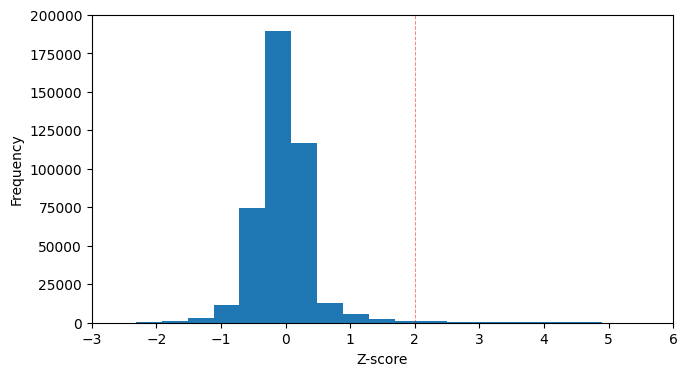

In [25]:
plt.figure(figsize=(7.5, 4))
nsP34['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
plt.xlim(-3,6)
plt.ylim(-0,200000)
plt.vlines(2, 0, 200000, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
#plt.savefig('results/DCA/nsP/mfdca_nsp34_Nterm_Zscore_hist.png', dpi=600, bbox_inches='tight')
plt.show()

In [26]:
nsP34['first_site_prot'] = nsP34['first_site'].apply(lambda x: 'nsP3' if x in range(nsp3_range[0], nsp3_range[1]+1) else 'nsP4')
nsP34['second_site_prot'] = nsP34['second_site'].apply(lambda x: 'nsP3' if x in range(nsp3_range[0], nsp3_range[1]+1) else 'nsP4')

nsP34 = nsP34[['first_site_prot', 'first_site', 'second_site_prot', 'second_site', 'Tuple', 'APC', 'Zscore']]

nsP34

,first_site_prot,first_site,second_site_prot,second_site,Tuple,APC,Zscore
9,nsP3,1392,nsP3,1617,"(1392, 1617)",1.418813,70.637266
14,nsP3,1348,nsP4,2234,"(1348, 2234)",1.267775,63.117654
19,nsP3,1392,nsP3,1490,"(1392, 1490)",1.160714,57.787483
21,nsP3,1398,nsP4,2008,"(1398, 2008)",1.147735,57.141280
28,nsP3,1531,nsP4,1884,"(1531, 1884)",0.968898,48.237662
...,...,...,...,...,...,...,...
2536861,nsP4,1682,nsP4,1896,"(1682, 1896)",-0.104480,-5.201790
2536863,nsP3,1398,nsP4,1896,"(1398, 1896)",-0.104697,-5.212594
2536870,nsP4,1724,nsP4,1896,"(1724, 1896)",-0.113459,-5.648824
2536875,nsP3,1392,nsP4,1896,"(1392, 1896)",-0.154851,-7.709596


In [27]:
df1 = nsP34.merge(neff, left_on='first_site', right_on='Position', how='left')
df1.rename(columns={'Neff': 'first_site_Neff', 'Residue':'first_site_residue'}, inplace=True)
df1.drop(columns='Position', axis=1, inplace=True)

df2 = df1.merge(neff, left_on='second_site', right_on='Position', how='left')
df2.rename(columns={'Neff': 'second_site_Neff', 'Residue':'second_site_residue'}, inplace=True)

cov_neff = df2[['Tuple', 
                'first_site_prot', 'first_site_residue', 'first_site', 'first_site_Neff',
                'second_site_prot', 'second_site_residue', 'second_site', 'second_site_Neff',
                            'APC', 'Zscore',]]

print("Number of possible significant interections", nsP34.query("APC > 0.5 & Zscore > 2").shape[0])

cov_neff = cov_neff.query("Zscore > 2")
cov_neff

Number of possible significant interections 59


,Tuple,first_site_prot,first_site_residue,first_site,first_site_Neff,second_site_prot,second_site_residue,second_site,second_site_Neff,APC,Zscore
0,"(1392, 1617)",nsP3,M,1392,4.189181,nsP3,I,1617,2.617878,1.418813,70.637266
1,"(1348, 2234)",nsP3,D,1348,5.705763,nsP4,S,2234,1.408190,1.267775,63.117654
2,"(1392, 1490)",nsP3,M,1392,4.189181,nsP3,Q,1490,3.792821,1.160714,57.787483
3,"(1398, 2008)",nsP3,V,1398,1.744773,nsP4,T,2008,4.556404,1.147735,57.141280
4,"(1531, 1884)",nsP3,Y,1531,1.863074,nsP4,A,1884,2.314389,0.968898,48.237662
...,...,...,...,...,...,...,...,...,...,...,...
4807,"(1717, 1959)",nsP4,T,1717,4.199315,nsP4,P,1959,1.011861,0.040195,2.001014
4808,"(1629, 1762)",nsP3,K,1629,2.139961,nsP4,S,1762,2.945902,0.040191,2.000802
4809,"(1450, 1819)",nsP3,G,1450,1.439563,nsP4,A,1819,2.604754,0.040188,2.000652
4810,"(1411, 1697)",nsP3,E,1411,1.016835,nsP4,S,1697,4.990098,0.040186,2.000560


In [28]:
nsP34_cov_neff = cov_neff[cov_neff['first_site_prot'] != cov_neff['second_site_prot']]
nsP34_cov_neff#.to_csv('results/DCA/nsP/plmDCA_nsp34_interactions.csv', index=False)

,Tuple,first_site_prot,first_site_residue,first_site,first_site_Neff,second_site_prot,second_site_residue,second_site,second_site_Neff,APC,Zscore
1,"(1348, 2234)",nsP3,D,1348,5.705763,nsP4,S,2234,1.408190,1.267775,63.117654
3,"(1398, 2008)",nsP3,V,1398,1.744773,nsP4,T,2008,4.556404,1.147735,57.141280
4,"(1531, 1884)",nsP3,Y,1531,1.863074,nsP4,A,1884,2.314389,0.968898,48.237662
6,"(1410, 1911)",nsP3,S,1410,2.988507,nsP4,F,1911,1.562666,0.930050,46.303556
7,"(1398, 1912)",nsP3,V,1398,1.744773,nsP4,A,1912,1.074220,0.928319,46.217378
...,...,...,...,...,...,...,...,...,...,...,...
4805,"(1395, 1890)",nsP3,T,1395,4.013454,nsP4,I,1890,2.000916,0.040203,2.001418
4806,"(1359, 2239)",nsP3,R,1359,2.734558,nsP4,E,2239,3.939197,0.040198,2.001196
4808,"(1629, 1762)",nsP3,K,1629,2.139961,nsP4,S,1762,2.945902,0.040191,2.000802
4809,"(1450, 1819)",nsP3,G,1450,1.439563,nsP4,A,1819,2.604754,0.040188,2.000652


## Annotations

In [29]:
mapping_nsp2 = dict(zip(range(536, 1334), range(1, 799)))
mapping_nsp3 = dict(zip(range(1334, 1642), range(1, 310)))
mapping_nsp4 = dict(zip(range(1643, 2254), range(1, 612)))

In [30]:
nsP24_cov_neff = nsP24_cov_neff.replace(mapping_nsp2)
nsP24_cov_neff = nsP24_cov_neff.replace(mapping_nsp4)
nsP24_cov_neff

,Tuple,first_site_prot,first_site_residue,first_site,first_site_Neff,second_site_prot,second_site_residue,second_site,second_site_Neff,APC,Zscore
1,"(1074, 1724)",nsP2,L,539,3.421185,nsP4,R,82,4.373344,1.538849,76.613376
3,"(680, 1697)",nsP2,E,145,2.433811,nsP4,S,55,4.990098,1.324988,65.966043
4,"(665, 1727)",nsP2,H,130,5.418004,nsP4,R,85,2.994622,1.283811,63.915992
6,"(1114, 1736)",nsP2,W,579,2.999011,nsP4,K,94,3.026277,1.198279,59.657703
7,"(1174, 2101)",nsP2,V,639,1.358160,nsP4,A,459,3.600721,1.189109,59.201155
...,...,...,...,...,...,...,...,...,...,...,...
17377,"(1042, 2186)",nsP2,K,507,2.445866,nsP4,E,544,2.701485,0.040194,2.000963
17379,"(576, 2159)",nsP2,I,41,1.612455,nsP4,G,517,1.621389,0.040190,2.000765
17384,"(589, 1959)",nsP2,S,54,2.937133,nsP4,P,317,1.011861,0.040185,2.000509
17388,"(714, 1919)",nsP2,I,179,2.765687,nsP4,P,277,1.392946,0.040180,2.000265


In [31]:
nsP34_cov_neff = nsP34_cov_neff.replace(mapping_nsp3)
nsP34_cov_neff = nsP34_cov_neff.replace(mapping_nsp4)
nsP34_cov_neff

,Tuple,first_site_prot,first_site_residue,first_site,first_site_Neff,second_site_prot,second_site_residue,second_site,second_site_Neff,APC,Zscore
1,"(1348, 2234)",nsP3,D,15,5.705763,nsP4,S,592,1.408190,1.267775,63.117654
3,"(1398, 2008)",nsP3,V,65,1.744773,nsP4,T,366,4.556404,1.147735,57.141280
4,"(1531, 1884)",nsP3,Y,198,1.863074,nsP4,A,242,2.314389,0.968898,48.237662
6,"(1410, 1911)",nsP3,S,77,2.988507,nsP4,F,269,1.562666,0.930050,46.303556
7,"(1398, 1912)",nsP3,V,65,1.744773,nsP4,A,270,1.074220,0.928319,46.217378
...,...,...,...,...,...,...,...,...,...,...,...
4805,"(1395, 1890)",nsP3,T,62,4.013454,nsP4,I,248,2.000916,0.040203,2.001418
4806,"(1359, 2239)",nsP3,R,26,2.734558,nsP4,E,597,3.939197,0.040198,2.001196
4808,"(1629, 1762)",nsP3,K,296,2.139961,nsP4,S,120,2.945902,0.040191,2.000802
4809,"(1450, 1819)",nsP3,G,117,1.439563,nsP4,A,177,2.604754,0.040188,2.000652


In [61]:
#nsP34_cov_neff['Pairs'] = nsP34_cov_neff.apply(lambda row: f"{row['first_site_prot']}{row['first_site']}_{row['second_site_prot']}{row['second_site']}", axis=1)
nsP34_cov_neff['Pairs'] = nsP34_cov_neff.apply(lambda row: (row['first_site'], row['second_site']+570), axis=1)
nsP34_cov_neff

,Tuple,first_site_prot,first_site_residue,first_site,first_site_Neff,second_site_prot,second_site_residue,second_site,second_site_Neff,APC,Zscore,Pairs
1,"(1348, 2234)",nsP3,D,15,5.705763,nsP4,S,592,1.408190,1.267775,63.117654,"(15, 1162)"
3,"(1398, 2008)",nsP3,V,65,1.744773,nsP4,T,366,4.556404,1.147735,57.141280,"(65, 936)"
4,"(1531, 1884)",nsP3,Y,198,1.863074,nsP4,A,242,2.314389,0.968898,48.237662,"(198, 812)"
6,"(1410, 1911)",nsP3,S,77,2.988507,nsP4,F,269,1.562666,0.930050,46.303556,"(77, 839)"
7,"(1398, 1912)",nsP3,V,65,1.744773,nsP4,A,270,1.074220,0.928319,46.217378,"(65, 840)"
...,...,...,...,...,...,...,...,...,...,...,...,...
4805,"(1395, 1890)",nsP3,T,62,4.013454,nsP4,I,248,2.000916,0.040203,2.001418,"(62, 818)"
4806,"(1359, 2239)",nsP3,R,26,2.734558,nsP4,E,597,3.939197,0.040198,2.001196,"(26, 1167)"
4808,"(1629, 1762)",nsP3,K,296,2.139961,nsP4,S,120,2.945902,0.040191,2.000802,"(296, 690)"
4809,"(1450, 1819)",nsP3,G,117,1.439563,nsP4,A,177,2.604754,0.040188,2.000652,"(117, 747)"


In [89]:
nsP34_cov_neff.query('second_site == 611')

,Tuple,first_site_prot,first_site_residue,first_site,first_site_Neff,second_site_prot,second_site_residue,second_site,second_site_Neff,APC,Zscore,Pairs
106,"(1534, 2253)",nsP3,L,201,1.537380,nsP4,K,611,1.075529,0.400437,19.936131,"(201, 1181)"
126,"(1582, 2253)",nsP3,D,249,2.095704,nsP4,K,611,1.075529,0.377234,18.780919,"(249, 1181)"
361,"(1403, 2253)",nsP3,G,70,1.096135,nsP4,K,611,1.075529,0.301310,15.000980,"(70, 1181)"
849,"(1641, 2253)",nsP3,V,308,2.004636,nsP4,K,611,1.075529,0.211010,10.505251,"(308, 1181)"
4686,"(1491, 2253)",nsP3,M,158,2.787247,nsP4,K,611,1.075529,0.041139,2.048009,"(158, 1181)"


In [90]:
611+570

1181

## Calculate residues distance

In [81]:
from Bio.PDB import PDBParser, NeighborSearch
import numpy as np

def compute_residue_contacts_alpha_CA(pdb_file, output_file, cutoff=4.0):
    # Parse the PDB file
    parser = PDBParser()
    structure = parser.get_structure('protein', pdb_file)

    # Collect all Cα atoms
    ca_atoms = [atom for residue in structure.get_residues() for atom in residue if atom.get_name() == 'CA']

    # Define NeighborSearch object for these Cα atoms
    ns = NeighborSearch(ca_atoms)

    # Define the sets of residues of interest
    roi = 309
    n_terminal_residues = [residue for residue in structure.get_residues() if residue.id[1] <= roi and residue.has_id('CA')]
    rest_of_protein_residues = [residue for residue in structure.get_residues() if residue.id[1] > roi and residue.has_id('CA')]
    #rest_of_protein_residues = [residue for residue in structure.get_residues() if residue.has_id('CA')]

    # Store residue contacts
    residue_contacts = []
    #cutoff = cutoff  # Define your distance cutoff in Angstroms

    for n_res in n_terminal_residues:
        if n_res.has_id('CA'):
            n_ca = n_res['CA']
            for r_res in rest_of_protein_residues:
                if r_res.has_id('CA'):
                    r_ca = r_res['CA']
                    # Calculate Euclidean distance
                    distance = np.linalg.norm(n_ca.coord - r_ca.coord)  
                    if distance <= cutoff:
                        residue_contacts.append((n_res, r_res, distance))

    with open(output_file, 'w') as f:
        f.write(f"Contact\tResidue1_Name\tResidue1_Pos\tResidue2_Name\tResidue2_Pos\tPairs\tDistance(Å)\n")
        for i, contact in enumerate(residue_contacts):
            f.write(f"{i+1}\t{contact[0].get_resname()}\t{contact[0].id[1]}\t{contact[1].get_resname()}\t{contact[1].id[1]}\t{(contact[0].id[1],contact[1].id[1])}\t{contact[2]:.2f}\n")

In [83]:
# define input and output files and the 
in_file = 'data/nsP/pdb/nsp34-alphafold-model.pdb'
out_file = 'data/nsP/pdb/nsp34-alphafold-model_compact_pairs_contact.txt'
compute_residue_contacts_alpha_CA(in_file, out_file, cutoff=100)

In [84]:
dists = pd.read_csv(out_file, sep='\t')
dists

,Contact,Residue1_Name,Residue1_Pos,Residue2_Name,Residue2_Pos,Pairs,Distance(Å)
0,1,ALA,1,LEU,310,"(1, 310)",25.96
1,2,ALA,1,PHE,311,"(1, 311)",23.84
2,3,ALA,1,ASP,312,"(1, 312)",20.94
3,4,ALA,1,HIS,313,"(1, 313)",21.04
4,5,ALA,1,ASN,314,"(1, 314)",17.51
...,...,...,...,...,...,...,...
257492,257493,LEU,309,TYR,1177,"(309, 1177)",53.96
257493,257494,LEU,309,GLY,1178,"(309, 1178)",57.07
257494,257495,LEU,309,GLY,1179,"(309, 1179)",59.75
257495,257496,LEU,309,PRO,1180,"(309, 1180)",62.33


In [85]:
dists['Pairs'] = dists['Pairs'].apply(lambda x: ast.literal_eval(x))
dists

,Contact,Residue1_Name,Residue1_Pos,Residue2_Name,Residue2_Pos,Pairs,Distance(Å)
0,1,ALA,1,LEU,310,"(1, 310)",25.96
1,2,ALA,1,PHE,311,"(1, 311)",23.84
2,3,ALA,1,ASP,312,"(1, 312)",20.94
3,4,ALA,1,HIS,313,"(1, 313)",21.04
4,5,ALA,1,ASN,314,"(1, 314)",17.51
...,...,...,...,...,...,...,...
257492,257493,LEU,309,TYR,1177,"(309, 1177)",53.96
257493,257494,LEU,309,GLY,1178,"(309, 1178)",57.07
257494,257495,LEU,309,GLY,1179,"(309, 1179)",59.75
257495,257496,LEU,309,PRO,1180,"(309, 1180)",62.33


In [112]:
drop_cols = ['Contact', 'Residue1_Name', 'Residue1_Pos', 'Residue2_Name', 'Residue2_Pos']
nsP34_cov_neff_dist = nsP34_cov_neff.merge(dists, on='Pairs', how='inner').drop(columns=drop_cols, axis=1)
nsP34_cov_neff_dist.to_excel('results/DCA/nsP/nsp34_interactions_Neff_DCA_Dist.xlsx', index=False)

In [111]:
nsP34_cov_neff_dist.query("`Distance(Å)` < 50").to_excel('results/DCA/nsP/nsp34_interactions_contacts.xlsx', index=False)